<p style="color:#737373; font-family:futura; font-size:200%;">Partial Differential Equations</p>
<p style="color:#737373; font-family:futura;">9 February 2021</p>

<p style="font-family:futura;">Schematic Representation of a Countercurrent Heat Exchanger</p>
<img src="diagram.png" style="float: center;" width=500 height=500/>

Divide the length of the heat exchanger into $N$ parts where the enthalpy is $H_j$ in the $j^{th}$ unit. 

<p style="font-family:futura;">Upwind Differencing</p>
Let's assume (for now) that $\rho$ is not a strong function of temperature. 

Hot side (backward difference):

$A_c \Delta z \rho_H H_H^{(j)} |_{t + \Delta t} - A_c \Delta z \rho_H H_H^{(j)} |_{t} = m_H H_H^{(j-1)}\Delta t - m_H H_H^{(j)}\Delta t - UP \Delta z (T_H^{(j)} - T_C^{(j)})\Delta t$

$$\implies \frac{dH_H^{(j)}}{dt} = \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j-1)} - \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j)} - \frac{UP}{A_c \rho_H} (T_H^{(j)} - T_C^{(j)})$$

---

Cold side (forward difference):

$A_c \Delta z \rho_C H_C^{(j)} |_{t + \Delta t} - A_c \Delta z \rho_C H_C^{(j)} |_{t} = m_C H_C^{(j+1)}\Delta t - m_C H_C^{(j)}\Delta t + UP \Delta z (T_H^{(j)} - T_C^{(j)})\Delta t$

$$\implies \frac{dH_C^{(j)}}{dt} = \frac{m_C}{A_c \rho_C \Delta z} H_H^{(j+1)} - \frac{m_H}{A_c \rho_C \Delta z} H_H^{(j)} + \frac{UP}{A_c \rho_C}  (T_H^{(j)} - T_C^{(j)})$$

---
(where $\frac{m}{A_c \rho} = \text{velocity}$)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import scipy.interpolate
import scipy.optimize
from matplotlib import style
from matplotlib.animation import FuncAnimation

from IPython.display import display, Math, Image
%config InlineBackend.figure_format = 'retina'

style.use("classic")

<p style="font-family:futura;">List of compounds</p>

In [2]:
data = pd.read_csv("CpData.csv").replace(np.NaN, 0)
data.index += 1
comp = data['Name']
MW = data['Mol. wt.']
Tmin = data['Tmin, K']
Tmax = data['Tmax, K']
C1 = data['C1']
C2 = data['C2']
C3 = data['C3']
C4 = data['C4']
C5 = data['C5']
data

,Name,CAS no.,Mol. wt.,C1,C2,C3,C4,C5,"Tmin, K","Tmax, K"
1,Acetaldehyde,75-07-0,44.053,115100.0,-433.0000,1.42500,0.000000,0.000000,150.15,294.00
2,Acetamide,60-35-5,59.067,102300.0,128.7000,0.00000,0.000000,0.000000,354.15,571.00
3,Acetic acid,64-19-7,60.052,139640.0,-320.8000,0.89850,0.000000,0.000000,289.81,391.05
4,Acetic anhydride,108-24-7,102.089,36600.0,511.0000,0.00000,0.000000,0.000000,250.00,350.00
5,Acetone,67-64-1,58.079,135600.0,-177.0000,0.28370,0.000689,0.000000,178.45,329.44
...,...,...,...,...,...,...,...,...,...,...
233,Water,7732-18-5,18.015,276370.0,-2090.1000,8.12500,-0.014116,0.000009,273.16,533.15
234,p-Xylene,106-42-3,106.165,-35500.0,1287.2000,-2.59900,0.002426,0.000000,286.41,600.00
235,m-Xylene,108-38-3,106.165,133860.0,7.8754,0.52265,0.000000,0.000000,217.00,540.15
236,o-Xylene,95-47-6,106.165,36500.0,1017.5000,-2.63000,0.003020,0.000000,247.98,417.58


In [3]:
compH = 'o-Dichlorobenzene'    # HOT fluid
compC = 'Ethylene glycol'    # COLD fluid

In [4]:
iH = comp.index[comp == compH].tolist()[0]
iC = comp.index[comp == compC].tolist()[0]

In [5]:
Tref = 293.15  # K

def H_H(T):  # T in K, H in J/kg
    return (C1[iH] * (T - Tref) + C2[iH] * (T ** 2 - Tref ** 2) / 2 +
            C3[iH] * (T ** 3 - Tref ** 3) / 3 + C4[iH] * (T ** 4 - Tref ** 4) / 4 +
            C5[iH] * (T ** 5 - Tref ** 5) / 5) / MW[iH]


def H_C(T):  # T in K, H in J/kg
    return (C1[iC] * (T - Tref) + C2[iC] * (T ** 2 - Tref ** 2) / 2 +
            C3[iC] * (T ** 3 - Tref ** 3) / 3 + C4[iC] * (T ** 4 - Tref ** 4) / 4 +
            C5[iC] * (T ** 5 - Tref ** 5) / 5) / MW[iC]

# Using linear interpolation to find temperature at a given enthalpy value

T = np.linspace(max(Tmin[iH], Tmin[iC]), min(Tmax[iH], Tmax[iC]), 500)
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

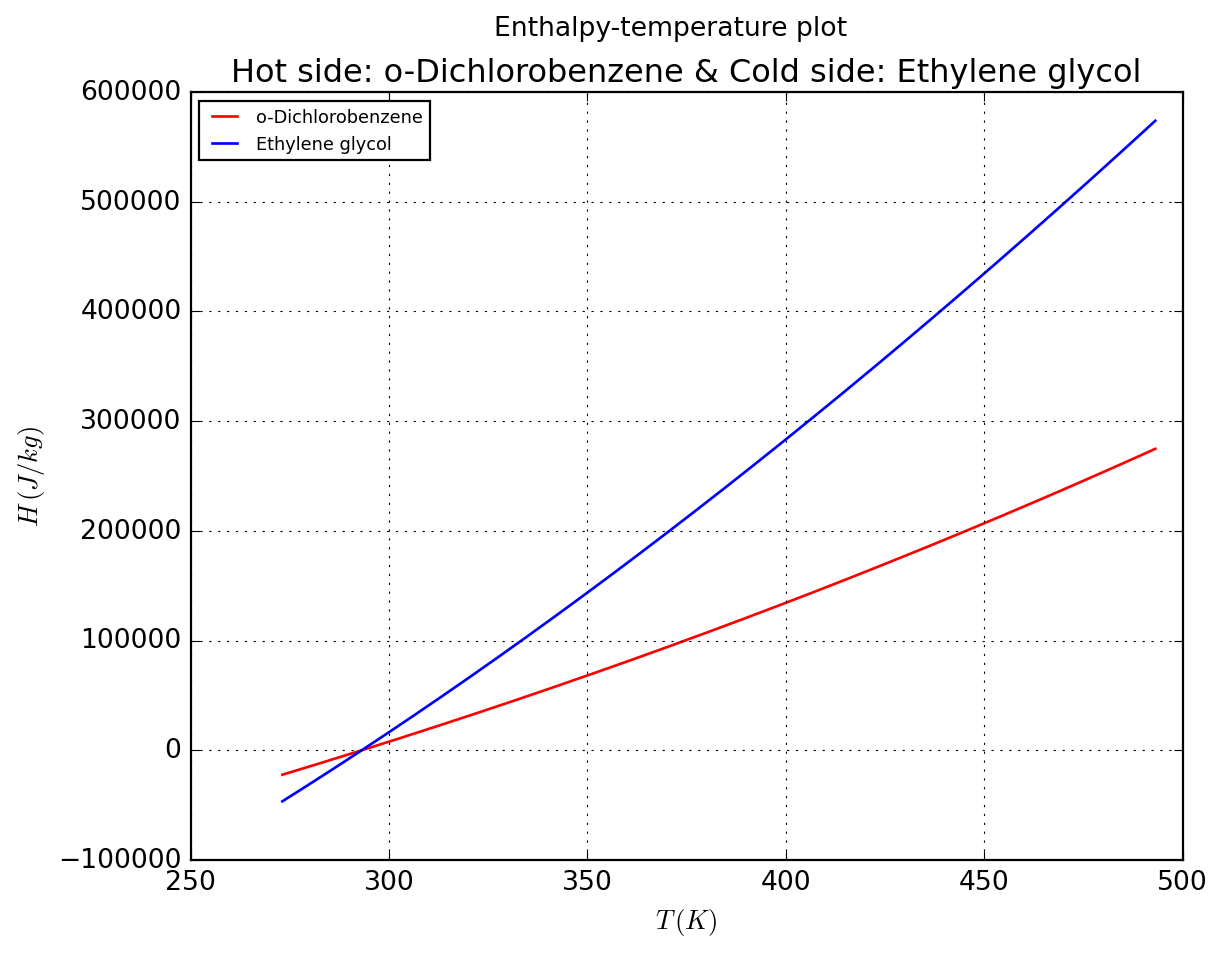

In [6]:
plt.figure(facecolor='white')
plt.grid()
plt.suptitle("Enthalpy-temperature plot")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(T, H_H(T), color='red', linewidth=1.2, label=compH)
plt.plot(T, H_C(T), color='blue', linewidth=1.2, label=compC)
plt.xlabel(r'$T\, (K)$')
plt.ylabel(r'$H\, (J/kg)$')
plt.legend(loc='best', fontsize=8);

In [7]:
class CounterCurrentHX:
    def __init__(self, n):
        self.U = 400.0  # W/m2-K
        self.P = np.pi * 0.1  # m2/m
        self.AcH = np.pi * 0.25 * 0.1 ** 2  # m2
        self.AcC = np.pi * 0.25 * 0.1 ** 2  # m2
        self.L = 1.0  # m
        
        self.rhoH = 1300 # kg/m3
        self.rhoC = 1100 # kg/m3
        
        self.mH = 0.08  # kg/s
        self.mC = 0.04  # kg/s
        
        self.T_Hin = 323.16  # K
        self.T_Cin = 303.16  # K
        
        self.n = n # Number of grid points

    def model(self, H, t): 
        H_hot = H[:self.n]
        H_cold = H[self.n:]

        T_hot = T_H(H_hot)
        T_cold = T_C(H_cold)
        
        H_Hin = H_H(self.T_Hin)
        H_Cin = H_C(self.T_Cin)
        
        dz = self.L / self.n
        
        dH_hotdt = np.zeros(self.n)
        dH_colddt = np.zeros(self.n)
        
        dH_hotdt[1:] = self.mH / (self.AcH * self.rhoH * dz) * H_hot[0:-1] - self.mH / (self.AcH * self.rhoH * dz) * H_hot[1:] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[1:] - T_cold[1:]) 
        dH_colddt[:-1] = self.mC / (self.AcC * self.rhoC * dz) * H_cold[1:] - self.mC / (self.AcC * self.rhoC * dz) * H_cold[:-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[:-1] - T_cold[:-1]) 
        
        dH_hotdt[0] = self.mH / (self.AcH * self.rhoH * dz) * H_Hin - self.mH / (self.AcH * self.rhoH * dz) * H_hot[0] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[0] - T_cold[0]) 
        dH_colddt[-1] = self.mC / (self.AcC * self.rhoC * dz) * H_Cin - self.mC / (self.AcC * self.rhoC * dz) * H_cold[-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[-1] - T_cold[-1]) 

        return list(dH_hotdt) + list(dH_colddt)

    def solve(self, t):
        Tini = np.ones(self.n * 2) * self.T_Cin
#         Tini[:self.n] = Tini[:self.n] * self.T_Hin
#         Tini[self.n:] = Tini[self.n:] * self.T_Cin
        H0 = np.zeros(self.n * 2)
        H0[:self.n] = H_H(Tini[:self.n])
        H0[self.n:] = H_C(Tini[self.n:])
        
        sol = scipy.integrate.odeint(self.model, H0, t)
        
        dz = self.L / self.n
        pos = [(i + 0.5) * dz for i in range(self.n)] 

        self.t = t
        self.pos = pos
        self.sol = sol

In [20]:
def get_solution(n, T):
    t = np.linspace(0, T, n)
    hx = CounterCurrentHX(n)
    hx.solve(t)
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.03 * hx.T_Hin)
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
    
    line1 = plt.plot([], 'r', label='Hot side - %s' % compH)[0]
    line2 = plt.plot([], 'b', label='Cold side - %s' % compC)[0]
    plt.legend(loc='best', fontsize=7)
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200);
    animation.save('animation.gif', writer='ffmpeg')
    return Image(url='animation.gif')

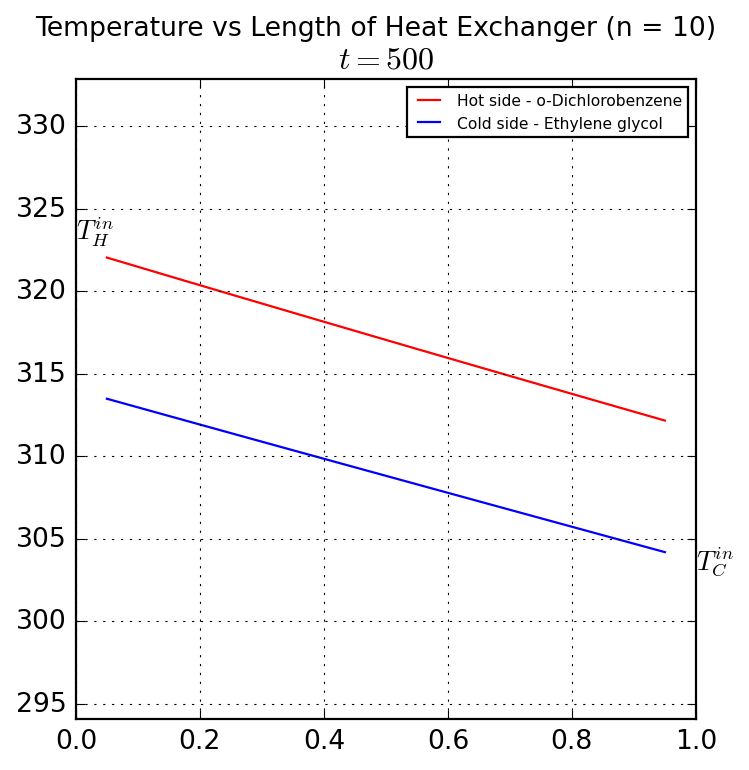

In [21]:
T = 500
get_solution(10, T)

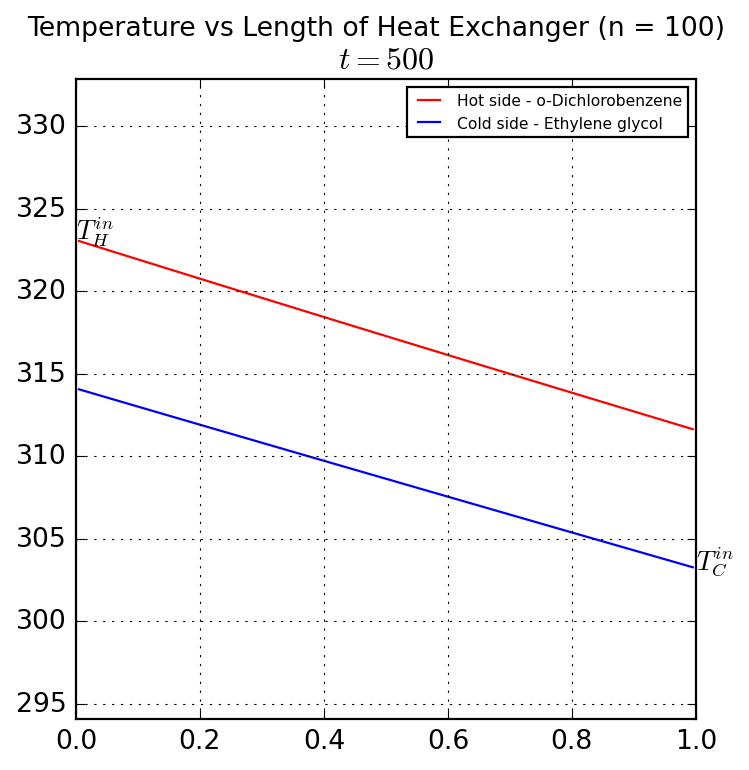

In [24]:
get_solution(100, T)

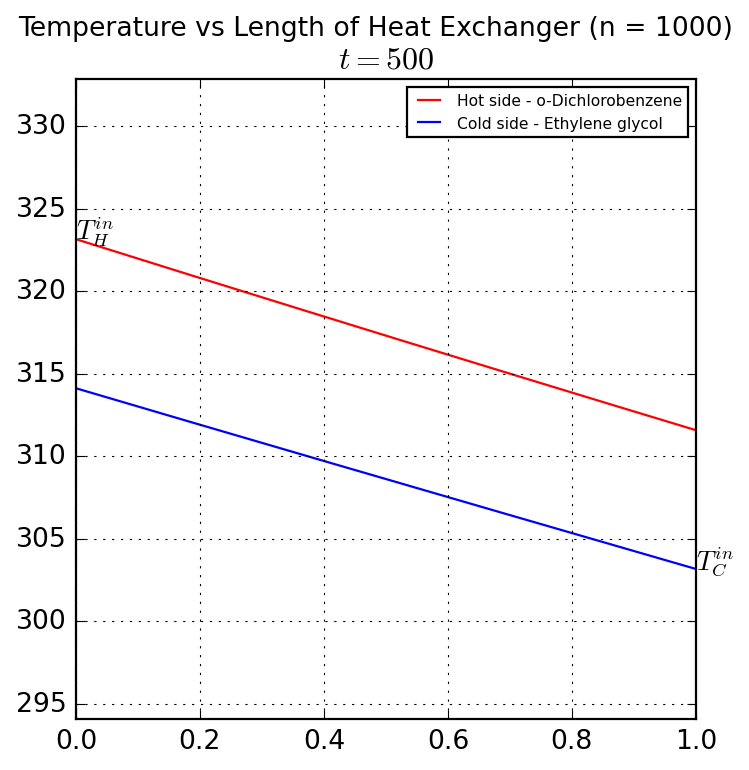

In [26]:
get_solution(1000, T)

---
<p style="color:#737373; font-family:futura;">Source: Perry, R. H., &amp; Green, D. W. (2008). Physical and Chemical Data. In Perry's chemical engineers' handbook (pp. 165-170). McGraw Hill.</p>